In [5]:
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import tensorflow as tf
import random as rn
from keras import backend as K
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

from Match_SOM import MATCHSOM
from utility import neuron_idx, idx_convert
from metrics import aveNN_ATT,Tau_G
from sklearn.model_selection import train_test_split
import pickle
import keras


import time
start = time.time()


xty = pd.read_csv('../data/Lalonde_sc.csv',index_col = 0)

data = xty.iloc[:,:-2].values

ATT = []

latent_dim = [10]

for dim in latent_dim: 
    
    train, test = train_test_split(xty, test_size=0.2,stratify = xty['assignment'], random_state = 0 )
    Xtrain,ytrain = train.iloc[:,0:-2].values,train.iloc[:,-2].astype(int)
    Xtest,ytest = test.iloc[:,0:-2].values,test.iloc[:,-2].astype(int)
    
    np.random.seed(0)
    rn.seed(0)
    config = tf.ConfigProto(intra_op_parallelism_threads=1,inter_op_parallelism_threads=1)
    tf.set_random_seed(0)
    sess = tf.Session(graph=tf.get_default_graph(), config=config)
    K.set_session(sess)
    
    side = int(round(np.sqrt(5*np.sqrt(xty.shape[0])))) 
    map_size=(side,side)  
    neuron_map = neuron_idx(map_size)  
    
    # Initialize model
    matchsom = MATCHSOM(encoder_dims=[ Xtrain.shape[-1], dim ], map_size=map_size)    
    optimizer = keras.optimizers.Adam(learning_rate=0.0001) #'adam' # 
    matchsom.initialize(ae_act='relu', ae_init='glorot_uniform')
    matchsom.compile(gamma=1, optimizer=optimizer)
    matchsom.fit(X_train = Xtrain, y_train=ytrain,
                X_val=Xtest, y_val=ytest,
                iterations=3000,
                som_iterations=3000,
                eval_interval=100,
                save_epochs=10,
                batch_size= 64,
                Tmax= 10,
                Tmin=0.1,
                decay= 'exponential')
        
    
    _, distance = matchsom.model.predict(data[2490:,:])
    bmu = np.argmin(distance,axis=1)
    bmu_idx = idx_convert(bmu,neuron_map)
    att = aveNN_ATT(xty.iloc[2490:,:].reset_index(drop = True),bmu_idx,'cityblock')  # 
    tau_g = Tau_G(xty.iloc[2490:,:].reset_index(drop = True),bmu_idx,'cityblock') #
    print(dim,att,tau_g)



Classifier was not pre-trained!
10 1020.4668663424508 149.41666666666666


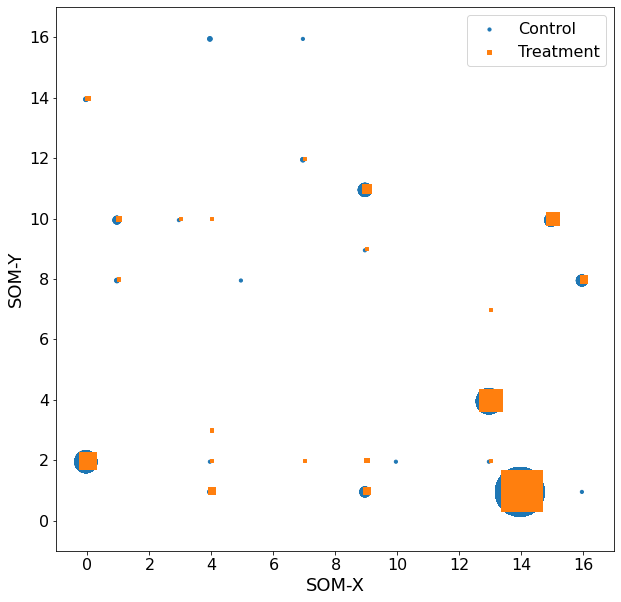

In [8]:

import matplotlib.pyplot as plt
from collections import Counter 

#test = xty
test = xty.iloc[2490:,:].reset_index(drop = True)

plt.figure(figsize=(10, 10))

# use different colors and markers for each label, control vs treatment
markers = ['o', 's']
colors = ['C0', 'C1']


for i in [0,1]: 
    if i ==0:
        x_vals = np.array(bmu_idx)[test.assignment==i][:,0]-0.05
        y_vals = np.array(bmu_idx)[test.assignment==i][:,1]-0.05
        
        combos = list(zip(x_vals, y_vals))
        weight_counter = Counter(combos)

        weights = [weight_counter[(x_vals[i], y_vals[i])] for i, _ in enumerate(x_vals)]


        plt.scatter(x_vals,y_vals,color = colors[i],marker = markers[i],s=10*np.array(weights), label ='Control')
    else:
        
        x_vals = np.array(bmu_idx)[test.assignment==i][:,0]+0.1
        y_vals = np.array(bmu_idx)[test.assignment==i][:,1]+0.1
        
        combos = list(zip(x_vals, y_vals))
        weight_counter = Counter(combos)

        weights = [weight_counter[(x_vals[i], y_vals[i])] for i, _ in enumerate(x_vals)]
        plt.scatter(np.array(bmu_idx)[test.assignment==i][:,0],np.array(bmu_idx)[test.assignment==i][:,1],color = colors[i],marker = markers[i],s=10*np.array(weights) ,label = 'Treatment')

plt.xlabel('SOM-X',fontsize = 18)
plt.ylabel('SOM-Y',fontsize= 18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim((-1,17))
plt.ylim((-1,17))


lgnd = plt.legend(loc= 'best',fontsize=16) #labels = ['control','treatment'],
lgnd.legendHandles[0]._sizes = [10]
lgnd.legendHandles[1]._sizes = [10]
plt.show()